In [3]:
import pandas as pd
import numpy as np

# Read the cleaned file into a DataFrame
df = pd.read_csv('../data/bgg_rating_threshold.csv', sep=';', engine='c')

# Convert the 'bgg_user_rating' column to numeric
df['bgg_user_rating'] = ((pd.to_numeric(df['bgg_user_rating'], errors='coerce'))*10).astype(np.uint8)

print("done")

done


In [4]:
from scipy.sparse import coo_matrix,csr_matrix
from sklearn.decomposition import TruncatedSVD
data = list(df.itertuples(index=False, name=None))
# Alternatively, you can use df['item'], df['user'], and df['review_score'] directly.

# Create unique mappings for items and users
unique_items = sorted(df['bgg_id'].unique())
unique_users = sorted(df['bgg_user_name'].unique())

item_to_index = {item: idx for idx, item in enumerate(unique_items)}
user_to_index = {user: idx for idx, user in enumerate(unique_users)}

# Prepare row indices, column indices, and data (review scores) using the DataFrame columns
rows = df['bgg_id'].map(item_to_index)
cols = df['bgg_user_name'].map(user_to_index)
scores = df['bgg_user_rating']

# Create a sparse matrix using the COO format:
sparse_matrix = csr_matrix(
    (scores, (rows, cols)),
    shape=(len(unique_items), len(unique_users))
)

# Optionally convert to CSR format for more efficient arithmetic operations
#sparse_matrix = sparse_matrix.tocsr()
print ("Sparse matrix created with shape:", sparse_matrix.shape)

Sparse matrix created with shape: (15738, 411956)


In [5]:
# # 1) Compute column sums and counts of stored entries
# col_sums   = np.bincount(sparse_matrix.indices, weights=sparse_matrix.data, minlength=sparse_matrix.shape[1])
# col_counts = np.bincount(sparse_matrix.indices, minlength=sparse_matrix.shape[1])

# # 2) Compute column means, with NaN for empty columns
# col_means = col_sums / col_counts
# col_means[col_counts == 0] = np.nan

# # 3) Convert sparse_matrix.data to float64 for compatibility
# sparse_matrix.data = sparse_matrix.data.astype(np.float64)

# # 4) Subtract the column means from each stored entry, in place
# sparse_matrix.data -= col_means[sparse_matrix.indices]

In [6]:
# Display the first 5 rows and columns of the sparse_matrix
print(sparse_matrix[:5, :5])

<Compressed Sparse Row sparse matrix of dtype 'uint8'
	with 1 stored elements and shape (5, 5)>
  Coords	Values
  (4, 2)	80


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
sparse_matrix = cosine_similarity(sparse_matrix, dense_output=True)

In [8]:
# Display the first 5 rows and columns of the sparse_matrix
print(sparse_matrix[:5, :5])

[[1.         0.05124506 0.27243588 0.1296068  0.27745892]
 [0.05124506 1.         0.05905128 0.05030473 0.08138042]
 [0.27243588 0.05905128 1.         0.09861386 0.31927219]
 [0.1296068  0.05030473 0.09861386 1.         0.09513554]
 [0.27745892 0.08138042 0.31927219 0.09513554 1.        ]]


In [52]:
import umap
reducer = umap.UMAP(metric='precomputed',n_jobs=-1,min_dist=0.1)
mapper=reducer.fit(np.asarray(1 - sparse_matrix))
coords=reducer.transform(np.asarray(1 - sparse_matrix))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
# Get the indices of the top 500 values for each row
top_500_indices = np.argsort(sparse_matrix, axis=1)[:, -150:]

In [11]:
# # Create a new matrix to store the data
filtered_matrix = np.zeros((top_500_indices.shape[0], top_500_indices.shape[1]))

# Populate the matrix with data from sparse_matrix
for row_idx in range(top_500_indices.shape[0]):
    filtered_matrix[row_idx] = sparse_matrix[row_idx, top_500_indices[row_idx]]  # Direct indexing for numpy.ndarray


In [12]:
import igraph as ig

# Extract indices and distances from neigh
# indices, dist, _ = neigh
weightss = filtered_matrix

# Create an edge list with weights
edges = []
weights = []
for i, neighbors in enumerate(np.asarray(top_500_indices)):
    for j, neighbor in enumerate(neighbors):
        if i != neighbor:  # Avoid self-loops
            edges.append((i, neighbor))
            weights.append(weightss[i, j])

# Create the igraph graph
g = ig.Graph(edges=edges, edge_attrs={"weight": weights}, directed=False)
print(g.summary())


IGRAPH U-W- 15738 2344962 -- 
+ attr: weight (e)


In [13]:
# t=g.community_leiden(objective_function="modularity", weights="weight")
# print(t.modularity)


In [14]:
# communities = t.membership

In [15]:
#Game–game weighted adjacency
# sparse_matrix = sparse_matrix.dot(sparse_matrix.T).todense()


In [16]:
# sim_matrix=pd.DataFrame(sparse_matrix).corr()

In [17]:
# from sklearn.metrics.pairwise import cosine_similarity

# sparse_matrix = cosine_similarity(sparse_matrix, dense_output=True)


In [18]:
# from sklearn.preprocessing import PowerTransformer

# scaler = PowerTransformer()
# scaler.fit(sparse_matrix)
# sparse_matrix_scaled = scaler.transform(sparse_matrix)

In [19]:
# # Set diagonal values to a very small number to exclude them from the top 500
# np.fill_diagonal(sparse_matrix, -np.inf)
# N = 1500
# # Get the indices of the top N values for each row
# top_N_indices = np.argsort(sparse_matrix, axis=1)[:, -N:]

# # Create a mask to keep only the top N values for each row
# mask = np.zeros_like(sparse_matrix, dtype=bool)
# rows = np.arange(sparse_matrix.shape[0])[:, None]
# mask[rows, top_N_indices] = True

# # Apply the mask to keep only the top N values, set others to 0
# filtered_sparse_matrix = np.where(mask, sparse_matrix, 0)

# # Restore the diagonal values to 0
# np.fill_diagonal(sparse_matrix, 0)

In [20]:
# from sklearn.neighbors import kneighbors_graph
# k = 1500
# # mode='distance' yields distances; mode='connectivity' yields 0/1 links
# knn_dist = kneighbors_graph(sparse_matrix, n_neighbors=k, mode='distance', include_self=False,n_jobs=-1)
# # Convert distances to weights, e.g. w = exp(-d)
# knn_weights = knn_dist.copy()
# knn_weights.data = np.exp(-knn_weights.data)


In [21]:
# import igraph as ig
# 5. Build an igraph Graph from the sparse matrix
#    Note: igraph expects a dense adjacency or edge list with weights
# d=knn_dist.data
# w = knn_weights.data
# g=ig.Graph.Weighted_Adjacency(filtered_sparse_matrix,attr='weight', loops=False)

In [22]:
import leidenalg as la
partition = la.find_partition(g, la.ModularityVertexPartition, weights='weight')
communities = partition.membership
print(partition.modularity)

0.5501801520803677


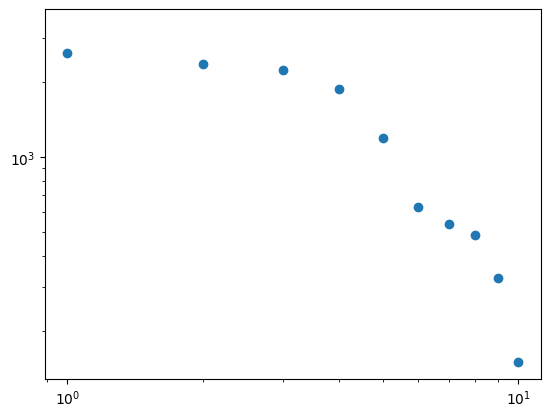

In [23]:
import matplotlib.pyplot as plt

unique_clusters, counts = np.unique(communities, return_counts=True)
cluster_counts = dict(zip(unique_clusters, counts))
plt.loglog(cluster_counts.keys(), cluster_counts.values(), 'o')


In [24]:
indices = [i for i, j in enumerate(communities) if j ==9]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
for index in indices:
    bgg_id = unique_items[index]
    name = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
    print(name.to_string())

12092    Berserk: Trading Card Game
5374    Black Stories 2
9068    Black Stories 3
26015    Black Stories: Mystery Edition
6918    Potion-Making: Practice
27381    Black Stories: Das Spiel
12529    Black Stories 4
23949    Jackal
21095    Black Stories: Movie Edition
27742    Black Stories Junior: White Stories
26553    Свинтус
17563    Black Stories: Real Crime Edition
14281    Black Stories 5
16642    Black Stories: Holiday Edition
9246    Black Stories: Funny Death Edition
23238    Black Stories: Christmas Edition
23349    Swintus 2.0
20697    The Big Fat Tomato Game
12350    Jackal: Treasure Island
19472    Black Stories: Mittelalter Edition
13997    Black Stories: Sex and Crime Edition
6456    Имаджинариум (Imaginarium)
13010    Black Stories: Shit Happens Edition
23531    Evolution: Random Mutations
15542    Nobody is Perfect: Mini Edition
6067    Stay Away!
84262    Каркассон: Королевский Подарок
15297    Mafia: Vendetta
16956    Tabletop Pathologic
10407    Бестиарий Сигиллума

In [25]:
# import umap
# reducer = umap.UMAP()

# filtered_sparse_matrix=np.where(filtered_sparse_matrix > 0, 1 / filtered_sparse_matrix, 0)
# reducer.fit(filtered_sparse_matrix,metric='precomputed')
# coords=reducer.transform(filtered_sparse_matrix)

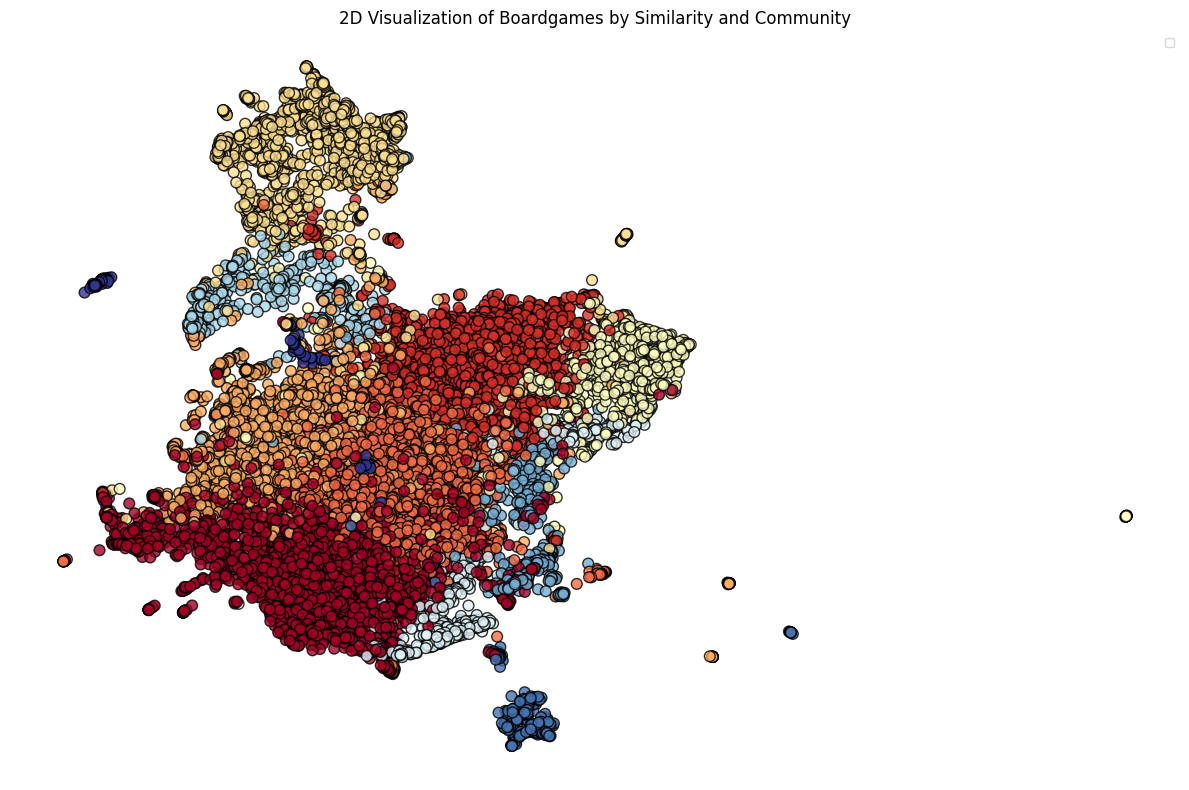

In [53]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# Step 5: Plotting
plt.figure(figsize=(12, 8))

plt.scatter(coords[:, 0], coords[:, 1],c=communities,cmap=plt.cm.RdYlBu ,s=60, alpha=0.8, edgecolor='k')

# Add legend without duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

plt.title("2D Visualization of Boardgames by Similarity and Community")
plt.axis('off')
plt.tight_layout()
plt.show()

<Axes: >

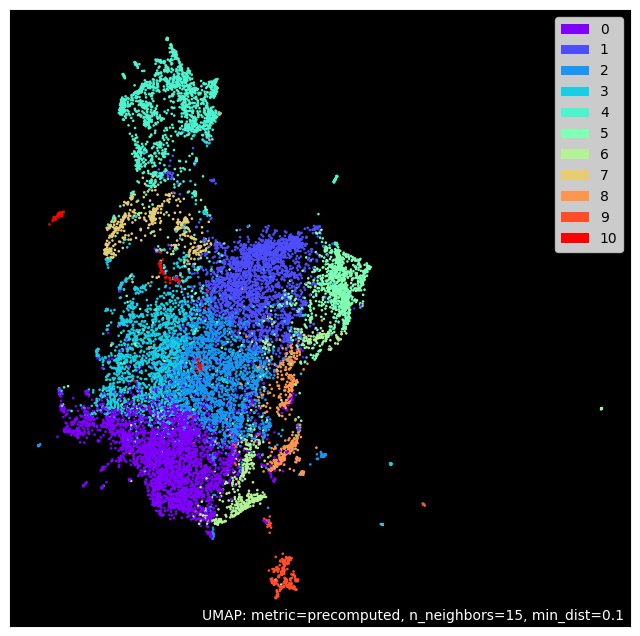

In [54]:
import umap.plot
import numpy as np

# Convert labels to a NumPy array
labels_array = np.array(communities)

# Plot the points
umap.plot.points(mapper, labels=labels_array, theme='fire')

In [ ]:
indices = [i for i, j in enumerate(communities)]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
names=[]
i=0
for index in indices:    
    bgg_id = unique_items[index]
    name = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
    names.append(name.to_string())
    i=i+1
hover_data = pd.DataFrame({'Name':np.array(names)})



In [56]:
umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=labels_array, hover_data=hover_data, point_size=4,background='black')
umap.plot.show(p)

Loading BokehJS ...

/home/codespace/.python/current/lib/python3.12/site-packages/umap/plot.py:895: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<Axes: >

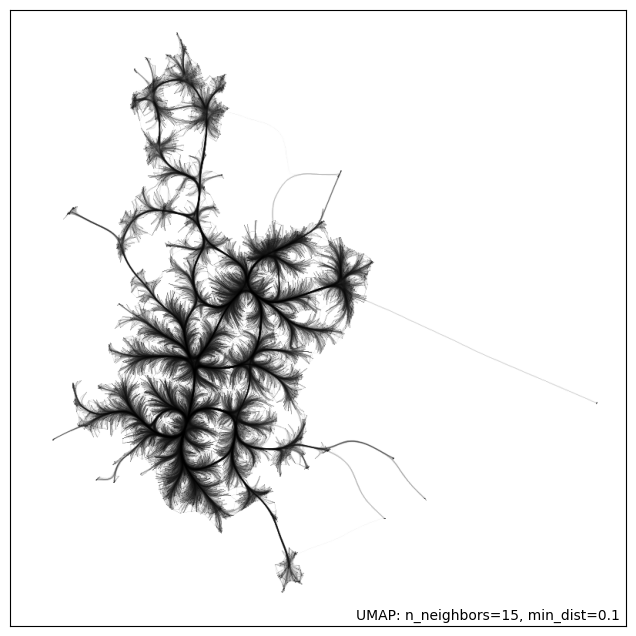

In [57]:
umap.plot.connectivity(mapper, edge_bundling='hammer')